# Text Processing with spaCy

In [322]:
import gzip
import pickle
import numpy as np
from configparser import ConfigParser
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import re
import string
punctuations = string.punctuation
import warnings
import matplotlib.pyplot as plt

% matplotlib inline

# spaCy
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    import spacy
    nlp = spacy.load('en')

# gensim
from gensim import corpora, models, similarities, matutils

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 
from sklearn.preprocessing import Normalizer, StandardScaler

# logging for gensim (set to INFO)
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Read in tweet data from Mongodb

In [2]:
config = ConfigParser()
config.read('../config.ini')

client = MongoClient("mongodb://{}:{}@{}/{}".format(
                        config.get('MongoConfig', 'user'),
                        config.get('MongoConfig', 'password'),
                        config.get('MongoConfig', 'host'),
                        config.get('MongoConfig', 'db')
                        ), int(config.get('MongoConfig', 'port')))

In [3]:
db = client.twitter_db

In [4]:
db.collection_names()

['Init', 'tweets', 'favorited_tweets']

In [5]:
db.favorited_tweets.count()

1113805

In [6]:
cursor = db.favorited_tweets.find({}).limit(10000)

In [7]:
tweet_data = [document  for document in cursor]

In [8]:
rawtext = [tweet['full_text'] for tweet in tweet_data]

rawtext[:5]

["100% correct. Congress must still act. This Administration will end DACA and has the authority to do so -- it just didn't do it legally. Yet. https://t.co/HxiDhioeMY",
 '#DACA renewals continue. Sessions &amp; DOJ overreached to skip Courts of Appeal. Congress must still act. #CleanDreamActNow #DreamActNow #Dreamers https://t.co/jUrwbqNU6p',
 'More courageous young people leading! #DreamActNow #CleanDreamAct https://t.co/WT0OuZbOVR',
 "Philando Castile's mom slams NRA chief LaPierre as a hypocrite - NY Daily News https://t.co/RLpLAw4VzX",
 'From one of the teen activists from #Parkland #BanAssaultWeapons #BoycottNRA https://t.co/RjnUwmCypF']

## Normalize Text

#### Clean, Tokenize and Vectorize (maybe Stem, Lemmatize)

In [9]:
def clean_tweet(tweet):
    """
    Function to remove urls, numbers and punctuation, and make lowercase
    """
    no_url = re.sub(r'http\S+', '', tweet)
    clean = re.sub(r'[^\w\s]', '', no_url)
    
    result = ''.join([str(i).replace('\n', ' ').lower() for i in clean if not i.isdigit()])

    return result

In [10]:
cleantext = [clean_tweet(i) for i in rawtext]
print(rawtext[1], '\n')
print(cleantext[1])

#DACA renewals continue. Sessions &amp; DOJ overreached to skip Courts of Appeal. Congress must still act. #CleanDreamActNow #DreamActNow #Dreamers https://t.co/jUrwbqNU6p 

daca renewals continue sessions amp doj overreached to skip courts of appeal congress must still act cleandreamactnow dreamactnow dreamers 


In [11]:
def spacy_tokenizer(tweet):
    """
    Utility function to remove stopwords, ignore pronouns and tokenize words before vectorizing
    """
    doc = nlp(tweet)
    tokens = [token.orth_ for token in doc if 
              (token.orth_ not in stopwords and token.pos_ in ['NOUN', 'PROPN', 'VERB', 'ADJ'])]
            
    return tokens

In [12]:
print(cleantext[0])

tokens_test = spacy_tokenizer(cleantext[0])
tokens_test

 correct congress must still act this administration will end daca and has the authority to do so  it just didnt do it legally yet 


['correct',
 'congress',
 'act',
 'administration',
 'end',
 'daca',
 'authority',
 'did']

In [13]:
#create vectorizer object to generate feature vectors, we will use custom spacy’s tokenizer
vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, 
                             ngram_range=(1,1))

In [14]:
vectorizer.fit(cleantext)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function spacy_tokenizer at 0x121ef7268>, use_idf=True,
        vocabulary=None)

In [15]:
counts = vectorizer.transform(cleantext).transpose()

In [16]:
np.shape(counts)

(15661, 10000)

In [17]:
pd.DataFrame(counts.toarray(), vectorizer.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a_clay_cahoon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aapi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aapiequalpay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
corpus = matutils.Sparse2Corpus(counts)

In [19]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

In [20]:
len(id2word)

15661

In [21]:
with open('../data/processed/word_features.pkl', 'wb') as wf:
    pickle.dump(id2word, wf)

## Dimensionality Reduction and Topic Modeling

### Try LDA to visualizae topic mappings using pyLDAvis
http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=0.51&term=

In [24]:
lda = models.LdaModel(corpus=corpus, num_topics=20, id2word=id2word, passes=5)

In [25]:
lda.print_topics()

[(0,
  '0.006*"trump" + 0.006*"awesome" + 0.006*"says" + 0.005*"truth" + 0.005*"olympic" + 0.005*"remove" + 0.005*"pyeongchang" + 0.005*"tweet" + 0.005*"redtraccoon" + 0.005*"make"'),
 (1,
  '0.009*"thank" + 0.009*"mueller" + 0.009*"ca" + 0.008*"facts" + 0.006*"m" + 0.006*"st" + 0.006*"join" + 0.005*"march" + 0.005*"wait" + 0.005*"amp"'),
 (2,
  '0.010*"banassaultweapons" + 0.008*"gracias" + 0.007*"america" + 0.007*"russian" + 0.006*"medical" + 0.005*"issue" + 0.005*"election" + 0.005*"look" + 0.005*"inside" + 0.004*"olympics"'),
 (3,
  '0.013*"good" + 0.008*"thanks" + 0.008*"does" + 0.007*"msnbc" + 0.006*"chicago" + 0.006*"illinois" + 0.006*"republicans" + 0.006*"guy" + 0.005*"closed" + 0.005*"fighting"'),
 (4,
  '0.009*"complicit" + 0.009*"rain" + 0.008*"party" + 0.007*"black" + 0.006*"right" + 0.006*"mfr" + 0.005*"stormtrack" + 0.005*"knew" + 0.005*"thing" + 0.005*"dearauntcrabby"'),
 (5,
  '0.009*"school" + 0.007*"police" + 0.007*"tax" + 0.006*"high" + 0.006*"lot" + 0.006*"live" + 

In [410]:
def find_topic_dist(tweet_index):
    print(rawtext[tweet_index], '\n')
    print(lda[corpus[tweet_index]])
    topic = max(lda[corpus[tweet_index]], key=lambda x:x[1])
    
    return topic

In [411]:
find_topic_dist(1000)

WEATHER ALERT: Areal Flood Watch for Perry, Morgan, Athens, Washington, Jackson and Vinton County until 1:00pm Sunday. https://t.co/rER0n11LOI 

[(0, 0.010975678), (1, 0.010975678), (2, 0.010975678), (3, 0.010975678), (4, 0.3476652), (5, 0.32406038), (6, 0.010975678), (7, 0.010975678), (8, 0.010975678), (9, 0.010975678), (10, 0.010975678), (11, 0.010975678), (12, 0.010975678), (13, 0.010975678), (14, 0.010975679), (15, 0.010975678), (16, 0.14168784), (17, 0.010975678), (18, 0.010975678), (19, 0.010975678)]


(4, 0.3473345)

In [412]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [413]:
tokens = [i[0] for i in vectorizer.vocabulary_.items()]
dictionary = corpora.Dictionary(np.array(tokens).reshape(-1, 1))
len(dictionary)

2018-03-01 16:50:56,649 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-01 16:50:56,724 : INFO : adding document #10000 to Dictionary(10000 unique tokens: ['correct', 'congress', 'act', 'administration', 'end']...)
2018-03-01 16:50:56,764 : INFO : built Dictionary(15661 unique tokens: ['correct', 'congress', 'act', 'administration', 'end']...) from 15661 documents (total 15661 corpus positions)


15661

In [414]:
data = pyLDAvis.gensim.prepare(lda, corpus, dictionary)

In [438]:
pyLDAvis.show(data)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]


127.0.0.1 - - [01/Mar/2018 17:12:01] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Mar/2018 17:12:01] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [01/Mar/2018 17:12:01] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [01/Mar/2018 17:12:01] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...


## Try LSA with two dimensions for interpretability

In [64]:
lsa = TruncatedSVD(n_components=2)
dtm_lsa = lsa.fit_transform(counts)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [65]:
x = [i[0] for i in dtm_lsa]
y = [i[1] for i in dtm_lsa]

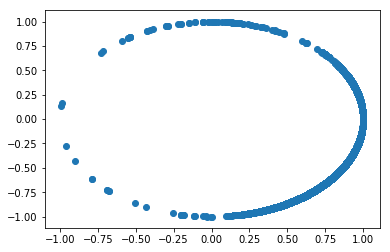

In [66]:
plt.scatter(x, y)

In [67]:
svd = TruncatedSVD(n_components=2)
svd.fit(counts)
svdfeatures_train = svd.transform(counts)

In [68]:
x = [i[0] for i in svdfeatures_train]
y = [i[1] for i in svdfeatures_train]

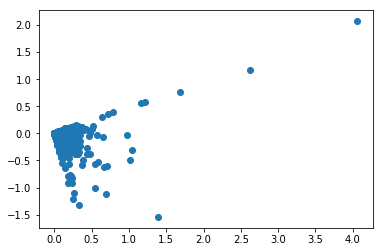

In [69]:
plt.scatter(x, y)

In [456]:
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()

In [ ]:
plot_PCA_2D(pcafeatures_train, target_names=digits.target_names)

# Topic Modeling for Smaller Data

Above, we created a term-document matrix for topic modeling with LDA. Because LSA and NMF require a document-term matrix, we'll create that below

In [135]:
dtm = vectorizer.fit_transform(cleantext)

In [214]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

## Try LSA

In [247]:
lsa = TruncatedSVD(n_components=6, random_state=42, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [248]:
lsa.explained_variance_ratio_

array([0.00347994, 0.00285627, 0.00333443, 0.00300378, 0.00301189,
       0.00233864])

In [249]:
print_top_words(lsa, vectorizer.get_feature_names(), 15)


Topic #0:
school shooting florida trump students high tv police gun student threats man county youtube did

Topic #1:
trump olympics winter county weather s flood gold alert usa warning pm team olympic youtube

Topic #2:
county flood weather warning alert pm police man cst yearold missing issued february youtube sat

Topic #3:
police man yearold missing tv s woman shot killed new son trump girl connectingyou says

Topic #4:
gold police usa man team medal olympics olympic hockey womens wins yearold curling missing shot

Topic #5:
realdonaldtrump s krassenstein edkrassen dwyer irdotnet nra iamororo know amp new good youtube high today



## Try NMF

In [294]:
nmf = NMF(n_components=12, random_state=42)

dtm_nmf = nmf.fit_transform(dtm)
dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

In [296]:
print_top_words(nmf, vectorizer.get_feature_names(), 25)


Topic #0:
school high student threat did district threats arrested kmanews charged middle students armed officer tv threatening delay enter shootings making teen dubbed safest resigns safety

Topic #1:
trump president ivanka teachers run thehill gun cnnpolitics campaign stop bump parade military shootings armed trumps stocks house does safetypindaily day arming americans safety big

Topic #2:
county flood weather warning alert pm cst sat issued washington watch advisory february saturday winter sunday coshocton vinton information marion d madison guernsey athens pickaway

Topic #3:
police man yearold tv missing shot killed woman connectingyou girl son boy searching arrested charged county search home car leads suspect houston death backyard buried

Topic #4:
gold usa medal team olympic hockey womens wins curling canada win medals feb silver ice cherylpreheim olympicson watch live mens streams bronze shootout wrong years

Topic #5:
s new says amp know people march netflix today expirin

The art is in first decideing what nubmer of topics to select and then in assigning each topic a name, which I'll do below

In [297]:
topics = ['teens_protest',
          'president_and_policies',
          'local_weather',
          'local_news',
          'olympics',
          'small_words_and_netflix',
          'foreign_affairs',
          'pundits_and_trolls',
          'florida_shooting2',
          'missing_manhunt',
          'taxes',
          'billy_dies']

In [317]:
tsne = TSNE(random_state=3211)
tsne_embedding = tsne.fit_transform(dtm_nmf)

In [318]:
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = dtm_nmf.argmax(axis=1)

In [319]:
from matplotlib import patches

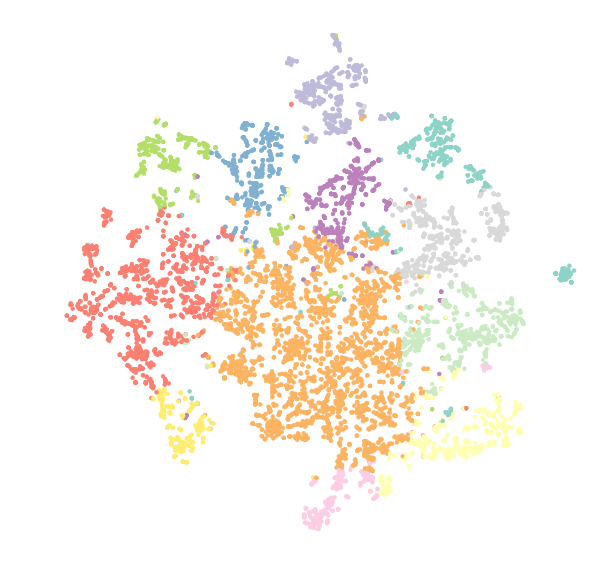

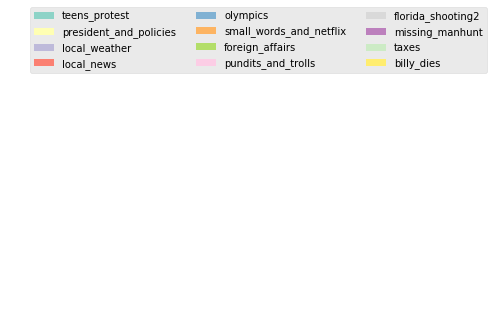

In [320]:
###code used to create the first plot for getting the colors 
plt.style.use('ggplot')

fig, axs = plt.subplots(1,1, figsize=(10, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)
    
legend_list = []

data = tsne_embedding
scatter = plt.scatter(data=data,x='x',y='y',s=15,c=data['hue'],cmap="Set3")
plt.axis('off')
plt.show()

# Show legend - need to reformat
colors = []
for i in range(len(topics)):
    idx = np.where(data['hue']==i)[0][0]
    color = scatter.get_facecolors()[idx]
    colors.append(color)
    legend_list.append(patches.Ellipse((0, 0), 1, 1, fc=color))
 
plt.figure(15, 3)
plt.legend(legend_list,topics,loc=(0,1),ncol=3, facecolor="white")
plt.axis('off')
plt.show()

### Try plotting in 3D

In [ ]:
tsne = TSNE(n_components=3, random_state=3211)
tsne_result = tsne.fit_transform(dtm_nmf)

In [342]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

tsne_result_scaled_df = pd.DataFrame(tsne_result_scaled,columns=['x','y','z'])
tsne_result_scaled_df['hue'] = dtm_nmf.argmax(axis=1)

In [324]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

In [382]:
label_to_id_dict = {v:i for i,v in enumerate(list(topics))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

label_ids = np.array([label_to_id_dict[id_to_label_dict[x]] for x in tsne_result_scaled_df['hue']])

(-2.5, 2.5)

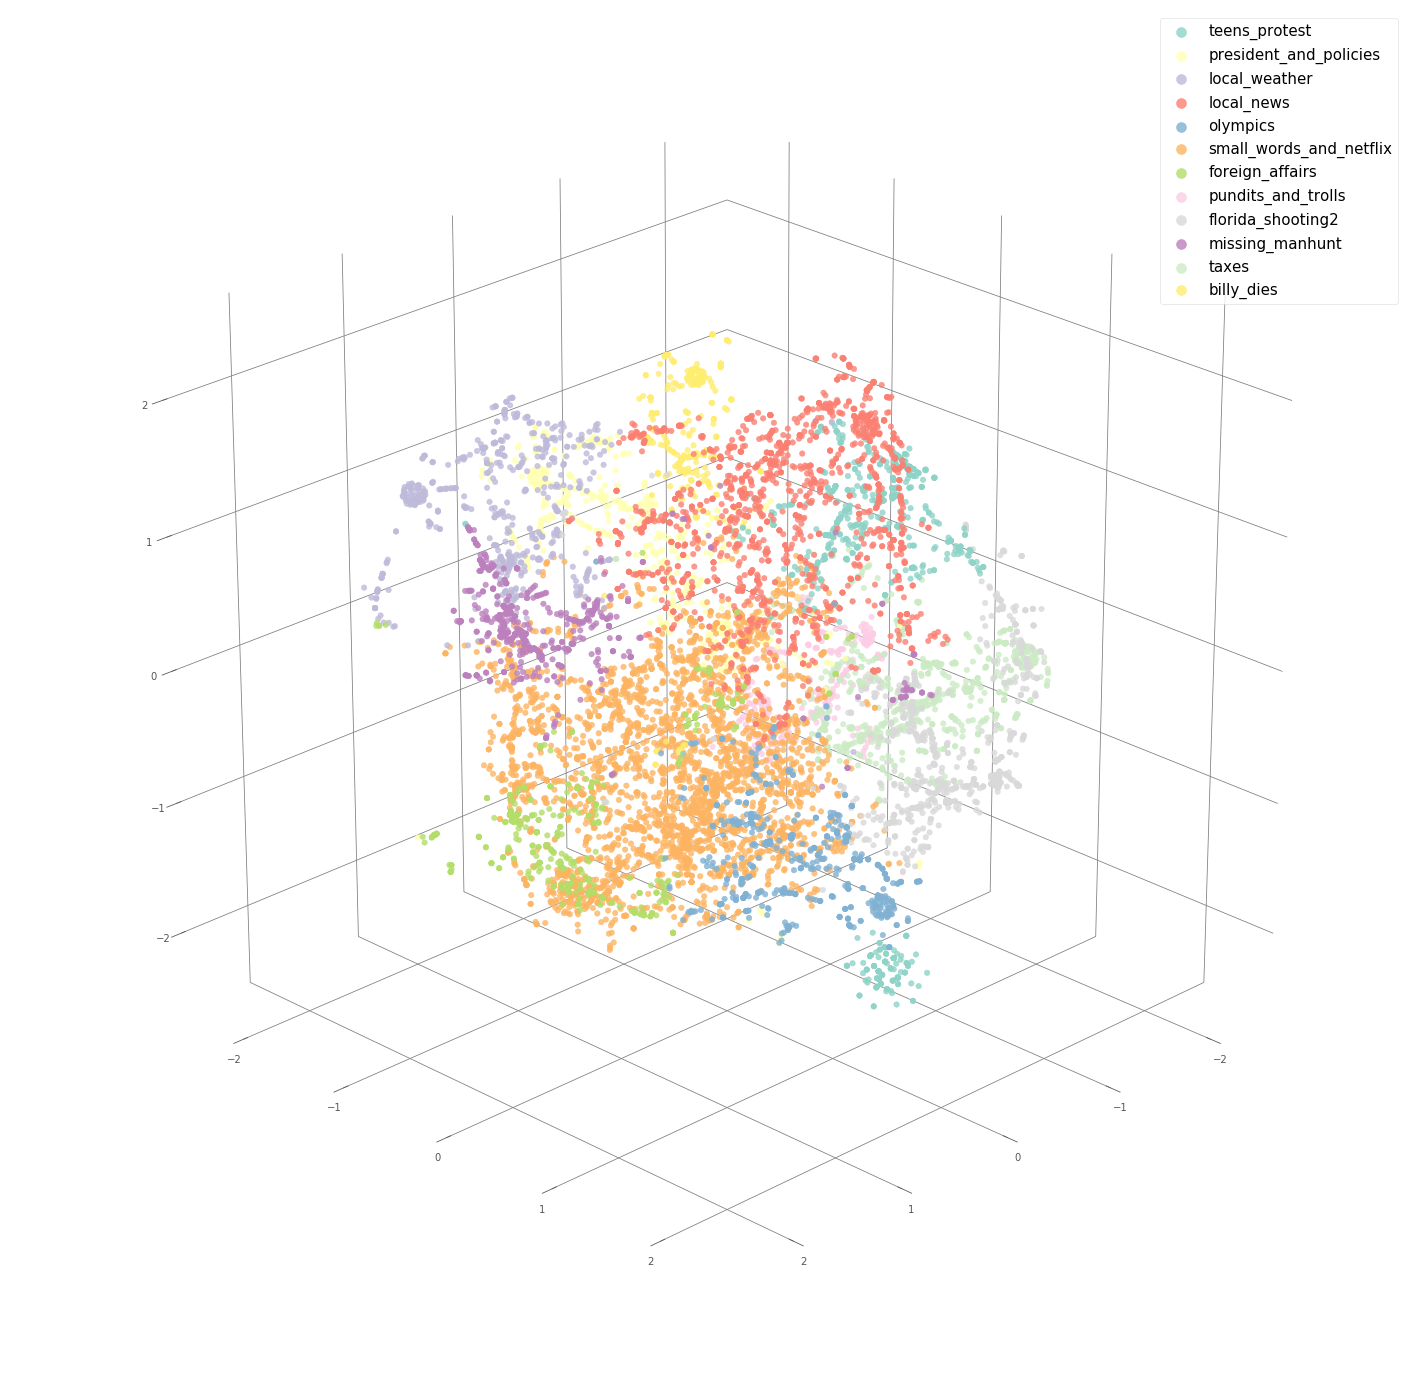

In [395]:
fig = plt.figure(figsize=(25,25), facecolor='white')
ax = fig.add_subplot(111,projection='3d')
ax.set_facecolor((1,1,1))
ax.xaxis.set_pane_color((1,1,1))
ax.yaxis.set_pane_color((1,1,1))
ax.zaxis.set_pane_color((1,1,1))

plt.grid()
plt.rcParams['grid.color'] = "grey"

nb_classes = len(np.unique(label_ids))
    
for label_id in np.unique(label_ids):
    ax.scatter(tsne_result_scaled[np.where(label_ids == label_id), 0],
                tsne_result_scaled[np.where(label_ids == label_id), 1],
                tsne_result_scaled[np.where(label_ids == label_id), 2],
                alpha=0.8,
                color= plt.cm.Set3(label_id / float(nb_classes)),
                marker='o',
                s=30,
                label=id_to_label_dict[label_id])
    
lgnd = ax.legend(loc='best', prop={'size': 15}, facecolor="white")

for i, t in enumerate(topics):
    lgnd.legendHandles[i]._sizes = [100]

ax.view_init(25, 45)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(-2.5, 2.5)

### Try plotting interactive 3D

In [336]:
import plotly.plotly as py
import plotly.graph_objs as go

In [ ]:
x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

x2, y2, z2 = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=12,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')